# "노드 간 연결성 예측"

> "그래프의 노드 연결성 예측 문제를 dgl 기본 예제로 이해한다."

- toc: true
- badges: true
- author: 단호진
- categories: [graph]

# 그래프 내 노드 연결성

그래프의 노드 간 엣지 혹은 링크 예측은 여러 응용이 존재한다. 사회 연결망 또는 소셜 네트워크에서 친구를 추천하거나, 아이템 추천 시스템, 지식 그래프를 완결시키는데 링크 예측을 사용할 수 있다. dgl 패키지가 제공하는 [기본 예제](https://docs.dgl.ai/tutorials/blitz/4_link_predict.html)를 통하여 링크 예측 문제를 이해하고, 패키지의 기본 용례를 살펴보겠다. 

예제에 사용하는 Cora 데이타셋은 인용 네트워크로 [Kipf의 논문](https://arxiv.org/abs/1609.02907)을 참고하자.

In [1]:
import dgl
import torch
import torch.nn as nn
import torch.nn.functional as F
import itertools
import numpy as np
import scipy.sparse as sp
from scipy.special import comb

print('torch: {}'.format(torch.__version__))
print('dgl:   {}'.format(dgl.__version__))
print()

import dgl.data

dataset = dgl.data.CoraGraphDataset()
g = dataset[0]

Using backend: pytorch


torch: 1.9.0+cu102
dgl:   0.6.1

  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.


Cora 데이타셋은 2708개의 노드와 10556 / 2 = 5278 개의 엣지가 있는 무향 그래프이다. 각 노드는 1433 차원의 특징 벡터로 표현되며, 7개 클래스로 레이블되어 있다. [그래프의 밀도](https://en.wikipedia.org/wiki/Dense_graph)는 0.144%이다. 

In [2]:
nCk = int(comb(2708, 2))
print(f'n choose k: {nCk}')
print(f'positive examples: {5278}')
print(f'negative examples: {nCk - 5278}')
print('Graph density: {:.3%}'.format(5278 / nCk))

n choose k: 3665278
positive examples: 5278
negative examples: 3660000
Graph density: 0.144%


In [3]:
[(k, v) for (k, v) in g.ndata.items()]

[('feat',
  tensor([[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]])),
 ('label', tensor([3, 4, 4,  ..., 3, 3, 3])),
 ('test_mask', tensor([False, False, False,  ...,  True,  True,  True])),
 ('train_mask', tensor([ True,  True,  True,  ..., False, False, False])),
 ('val_mask', tensor([False, False, False,  ..., False, False, False]))]

In [4]:
g.edges()

(tensor([   0,    0,    0,  ..., 2707, 2707, 2707]),
 tensor([ 633, 1862, 2582,  ...,  598, 1473, 2706]))

## 가정

임의로 두 노드 사이에 엣지가 있을 확률은 매우 낮다. 주어진 엣지를 positive 사례라고 부르자. 그리고 나머지 가능한 엣지에서 positive 사례를 찾을 가능성은 그래프 밀도 정도라 가정하자. positive example 수 만큼 추가로 사례를 추출하여 negative 사례라고 하자. negative 사례에 극소수는 실제로 엣지가 존재할 수 있지만 노이즈로 간주한다. positive/negative 사례로 나누고 분류 문제로 문제를 구성하여 링크 예측 문제를 해결하겠다.

### negative 사례 추출의 이해

인접 행렬은 엣지의 유무를 확인할 수 있으므로 negative 사례를 추출하는데 사용할 수 있다.

In [5]:
import matplotlib.pyplot as plt
import networkx as nx

%matplotlib inline

In [6]:
u = np.array([1, 1, 2, 2, 5, 3, 4, 2, 5, 3, 5, 4, 4, 6])
v = np.array([2, 5, 3, 5, 4, 4, 6, 1, 1, 2, 2, 5, 3, 4])

G = nx.Graph()
G.add_edges_from(np.c_[u, v])
G.number_of_nodes(), G.number_of_edges()

(6, 7)

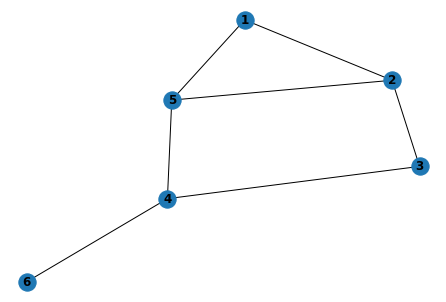

In [7]:
nx.draw(G, with_labels=True, font_weight='bold')

In [8]:
adj = sp.coo_matrix((np.ones(len(u)), (u - 1, v - 1)))
adj.todense()

matrix([[0., 1., 0., 0., 1., 0.],
        [1., 0., 1., 0., 1., 0.],
        [0., 1., 0., 1., 0., 0.],
        [0., 0., 1., 0., 1., 1.],
        [1., 1., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0., 0.]])

In [9]:
adj_neg = 1 - adj.todense() - np.eye(6)
adj_neg

matrix([[0., 0., 1., 1., 0., 1.],
        [0., 0., 0., 1., 0., 1.],
        [1., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 1.],
        [1., 1., 1., 0., 1., 0.]])

In [10]:
np.where(adj_neg != 0)

(array([0, 0, 0, 1, 1, 2, 2, 2, 3, 3, 4, 4, 5, 5, 5, 5]),
 array([2, 3, 5, 3, 5, 0, 4, 5, 0, 1, 2, 5, 0, 1, 2, 4]))

### negative 사례 추출과 훈련 및 검정 데이타 준비

양방향 엣지를 가지고 있으므로 검정 데이타가 누구 되지 않도록 주의해서 분할하였다. 각 노드의 특징 평가를 위하여 tr_g, 엣지 점수 평가를 위하여 tr_p_g, te_p_g, tr_n_g, te_n_g 그래프를 준비하였다. 

In [11]:
u, v = g.edges()
p_edges = np.c_[u.numpy(), v.numpy()]
p_edges = np.r_[[e for e in p_edges if e[0] < e[1]]]
num_edges = len(p_edges)
num_train = int(num_edges * 0.8)
np.random.shuffle(p_edges)
tr_p_edges = p_edges[:num_train]
tr_p_edges = np.r_[tr_p_edges, tr_p_edges[:, [1, 0]]]
tr_p_g = dgl.graph((tr_p_edges[:, 0], tr_p_edges[:, 1]), num_nodes=g.number_of_nodes())

te_p_edges = p_edges[num_train:]
te_p_edges = np.r_[te_p_edges, te_p_edges[:, [1, 0]]]
te_p_g = dgl.graph((te_p_edges[:, 0], te_p_edges[:, 1]), num_nodes=g.number_of_nodes())

tr_p_g, te_p_g

(Graph(num_nodes=2708, num_edges=8444,
       ndata_schemes={}
       edata_schemes={}),
 Graph(num_nodes=2708, num_edges=2112,
       ndata_schemes={}
       edata_schemes={}))

In [12]:
te_p_edges_set = {tuple(e) for e in te_p_edges}

eids = [k for (k, e) in enumerate(zip(u.numpy(), v.numpy())) if e in te_p_edges_set]
len(eids), eids[:10]

(2112, [1, 7, 8, 9, 11, 18, 23, 38, 40, 41])

In [13]:
tr_g = dgl.remove_edges(g, eids)
tr_g

Graph(num_nodes=2708, num_edges=8444,
      ndata_schemes={'feat': Scheme(shape=(1433,), dtype=torch.float32), 'label': Scheme(shape=(), dtype=torch.int64), 'test_mask': Scheme(shape=(), dtype=torch.bool), 'train_mask': Scheme(shape=(), dtype=torch.bool), 'val_mask': Scheme(shape=(), dtype=torch.bool)}
      edata_schemes={})

In [14]:
# twice edges of negative graph
# num_edges = num_edges * 2
# num_train = num_train * 2

adj = sp.coo_matrix((np.ones(g.number_of_edges()), (u.numpy(), v.numpy())))
adj_neg = 1 - adj.todense() - np.eye(g.number_of_nodes())
u_neg, v_neg = np.where(adj_neg != 0)

n_edges = np.r_[[uv for uv in np.c_[u_neg, v_neg] if uv[0] < uv[1]]]
np.random.shuffle(n_edges)
tr_n_edges = n_edges[:num_train]
tr_n_edges = np.r_[tr_n_edges, tr_n_edges[:, [1, 0]]]
tr_n_g = dgl.graph((tr_n_edges[:, 0], tr_n_edges[:, 1]), num_nodes=g.number_of_nodes())

te_n_edges = n_edges[num_train:num_edges]
te_n_edges = np.r_[te_n_edges, te_n_edges[:, [1, 0]]]
te_n_g = dgl.graph((te_n_edges[:, 0], te_n_edges[:, 1]), num_nodes=g.number_of_nodes())

tr_n_g, te_n_g

(Graph(num_nodes=2708, num_edges=8444,
       ndata_schemes={}
       edata_schemes={}),
 Graph(num_nodes=2708, num_edges=2112,
       ndata_schemes={}
       edata_schemes={}))

## GraphSAGE model

링크를 예측 문제는 우리가 가진 그래프의 엣지 정보가 불완전하다는 것을 의미한다. 정확한 그래프 라플라스 행렬을 알 지 못하므로 GAGEConv 모델을 이용한다. SAGE는 Sample & Aggregate에서 나온 말이다.

In [15]:
from dgl.nn import SAGEConv


class GraphSAGE(nn.Module):
    def __init__(self, in_feats, h_feats):
        super().__init__()
        self.conv1 = SAGEConv(in_feats, h_feats, 'mean')
        self.conv2 = SAGEConv(h_feats, h_feats, 'mean')
        
    def forward(self, g, in_feat):
        h = F.relu(self.conv1(g, in_feat))
        h = self.conv2(g, h)
        return h

## EdgeScore model

그래프에서 각 노드의 특징으로부터 엣지의 특성값을 도출하는 모델을 작성하였다.

In [16]:
class EdgeScore(nn.Module):  # original name: MLPPredictor
    def __init__(self, h_feats):
        super().__init__()
        self.W1 = nn.Linear(h_feats * 2, h_feats)
        self.W2 = nn.Linear(h_feats, 1)

    def apply_edges(self, edges):
        """
        Computes a scalar score for each edge of the given graph.

        Parameters
        ----------
        edges :
            Has three members ``src``, ``dst`` and ``data``, each of
            which is a dictionary representing the features of the
            source nodes, the destination nodes, and the edges
            themselves.

        Returns
        -------
        dict
            A dictionary of new edge features.
        """
        h = torch.cat([edges.src['h'], edges.dst['h']], 1)
        return {'score': self.W2(F.relu(self.W1(h))).squeeze(1)}

    def forward(self, g, h):
        with g.local_scope():
            g.ndata['h'] = h
            g.apply_edges(self.apply_edges)
            return g.edata['score']

In [17]:
def compute_loss(pos_score, neg_score):
    scores = torch.cat([pos_score, neg_score])
    labels = torch.cat([torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])])
    return F.binary_cross_entropy_with_logits(scores, labels)

def compute_auc(pos_score, neg_score):
    scores = torch.cat([pos_score, neg_score]).numpy()
    labels = torch.cat(
        [torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])]).numpy()
    return roc_auc_score(labels, scores)

In [18]:
node_feature_model = GraphSAGE(tr_g.ndata['feat'].shape[1], 32)
edge_score_model = EdgeScore(32)

optimizer = torch.optim.Adam(
    itertools.chain(node_feature_model.parameters(), edge_score_model.parameters()), lr=0.001)

# ----------- 4. training -------------------------------- #
all_logits = []
for epoch in range(1, 61):
    # forward
    h = node_feature_model(tr_g, tr_g.ndata['feat'])
    pos_score = edge_score_model(tr_p_g, h)
    neg_score = edge_score_model(tr_n_g, h)
    loss = compute_loss(pos_score, neg_score)

    # backward
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 5 == 0:
        with torch.no_grad():
            pos_score = edge_score_model(te_p_g, h)
            neg_score = edge_score_model(te_n_g, h)
            va_loss = compute_loss(pos_score, neg_score)
        print(f'Epoch {epoch:03d}, loss: {loss:.3f} va loss: {va_loss:.3f}')

# ----------- 5. check results ------------------------ #
print()

from sklearn.metrics import roc_auc_score
with torch.no_grad():
    pos_score = edge_score_model(te_p_g, h)
    neg_score = edge_score_model(te_n_g, h)
    print('AUC', compute_auc(pos_score, neg_score))

Epoch 005, loss: 0.693 va loss: 0.693
Epoch 010, loss: 0.691 va loss: 0.693
Epoch 015, loss: 0.689 va loss: 0.692
Epoch 020, loss: 0.686 va loss: 0.691
Epoch 025, loss: 0.680 va loss: 0.688
Epoch 030, loss: 0.673 va loss: 0.685
Epoch 035, loss: 0.662 va loss: 0.681
Epoch 040, loss: 0.647 va loss: 0.676
Epoch 045, loss: 0.629 va loss: 0.672
Epoch 050, loss: 0.608 va loss: 0.671
Epoch 055, loss: 0.586 va loss: 0.676
Epoch 060, loss: 0.564 va loss: 0.690

AUC 0.6191352444903581


## 마무리

dgl 패키지를 기본 예제를 통하여 링크 예측 문제를 살펴보면서 dgl 패키지는 코드 가독성이 높다는 인상을 받았다. 즉, dgl 패키지를 처음 접해도 그래프에 대한 개념만 갖춘다면 내 생각을 코드로 구성하여 실험해 보기 쉽다는 뜻으로, 여러 응용을 시도해 보기 좋은 패키지이다. 